In [2]:
import numpy as np
import crocoddyl
import torch
import torch.nn as nn
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from policy_network import PolicyNetwork
from helper import Datagen
from helper import Solver

In [3]:
torch.set_default_dtype(torch.double)
torch.cuda.empty_cache()

In [7]:
BATCHSIZE        = 32
TRAJCECTORIES    = 1000
lr               = 1e-3
EPOCHS           = 3000
HORIZON          = 100
DECAY            = 5e-6
PRECISION        = 1e-9
MAXITERS         = 1000
DEVICE           = 'cuda'

In [4]:
#....... Initlialize an empty net

neural_net = PolicyNetwork(state_dims=3, horizon=HORIZON+1, policy_dims=3, fc1_dims=100, fc2_dims=100,fc3_dims=100, activation=nn.ReLU6(), device = DEVICE)



#......... Training Data Generation

starting_points         = Datagen.griddedData(n_points=TRAJCECTORIES)
x_train, y_train         = [], []
for starting_point in starting_points:
    model               = crocoddyl.ActionModelUnicycle()
    model.costWeights   = np.array([1.,1.]).T
    problem             = crocoddyl.ShootingProblem(starting_point.T, [model]*HORIZON, model)
    ddp                 = crocoddyl.SolverDDP(problem)
    ddp.th_stop         = PRECISION
    ddp.solve([], [], MAXITERS)
    xs                  = np.array(ddp.xs)
    xs                  = xs[:,:]
    xs                  = xs.flatten().tolist()
    x_train.append(starting_point)
    y_train.append(xs)

x_train = np.array(x_train)
y_train = np.array(y_train)


x_test  = x_train[0:100,:]
y_test  = y_train[0:100,:]

x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)

x_test = torch.Tensor(x_test).to(DEVICE)
y_test = torch.Tensor(y_test).to(DEVICE)


# Convert to torch dataloader
dataset = torch.utils.data.TensorDataset(x_train, y_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = BATCHSIZE, shuffle=True)

#......  CRITERIA
criterion1 = torch.nn.MSELoss(reduction='sum')
criterion2 = torch.nn.L1Loss(reduction='mean')


#.......  OPTIMIZER
optimizer = torch.optim.ASGD(neural_net.parameters(), lr = lr, lambd=0.0001, alpha=0.75, t0=1000000.0, weight_decay= DECAY)
#optimizer = torch.optim.SGD(neural_net.parameters(), lr = lr, momentum=0.9, weight_decay=DECAY, nesterov=True)
#optimizer = torch.optim.Adam(neural_net.parameters(), lr = lr, betas=[0.5, 0.9], weight_decay=DECAY)

for epoch in range(EPOCHS):
    for data, target in dataloader:
        neural_net.train()
        optimizer.zero_grad()

        data        = data.to(DEVICE)
        target      = target.to(DEVICE)
        
        output      = neural_net(data)
        loss        = torch.sqrt(criterion1(output, target)) + criterion1(output, target)
        
        loss.backward()
        optimizer.step()

    prediction  = neural_net(x_test)
    mse         = torch.mean((prediction-y_test)**2)
    mae         = torch.mean(torch.abs(prediction-y_test))
    print(f"Epoch {epoch+1} :: mse = {mse}, mae = {mae}")


2717 :: mse = 0.0001176750946047409, mae = 0.006276279267443083
Epoch 2718 :: mse = 9.457303562824657e-05, mae = 0.005782199585410943
Epoch 2719 :: mse = 9.265162310641463e-05, mae = 0.005720672601458955
Epoch 2720 :: mse = 0.0001045671028429567, mae = 0.006022487614459449
Epoch 2721 :: mse = 0.00011342839222789109, mae = 0.006192495421026836
Epoch 2722 :: mse = 9.804806204459175e-05, mae = 0.006082052158249525
Epoch 2723 :: mse = 0.00010340049261214009, mae = 0.0058274871976997066
Epoch 2724 :: mse = 9.286635193240489e-05, mae = 0.0057814147384357625
Epoch 2725 :: mse = 0.00011729325716308895, mae = 0.006151263166567098
Epoch 2726 :: mse = 8.156176131602066e-05, mae = 0.005424878290294373
Epoch 2727 :: mse = 0.00012414837882239783, mae = 0.0062799301940563565
Epoch 2728 :: mse = 8.360951810182471e-05, mae = 0.005524853916091905
Epoch 2729 :: mse = 0.00011052442314792984, mae = 0.006079344155725382
Epoch 2730 :: mse = 0.0001515732327756591, mae = 0.006868989055616851
Epoch 2731 :: mse 

In [4]:
neural_net = torch.load("warmNet.pth")

In [8]:
#......... Sanity Check
#x  = [np.random.uniform(-1.5,1.5), np.random.uniform(-1.5,1.5), np.random.uniform(-np.pi/4, np.pi/4)]
x = [-1., -1., 1.]  #x,y,theta

np.round_(x, 4)

array([-1., -1.,  1.])

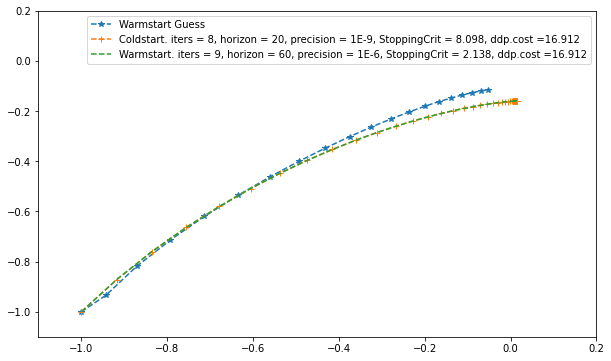

In [10]:

h1 = 20
h2 = 20
x1 = torch.Tensor(x).to(DEVICE)
guess = neural_net.guessAPolicy(x1)

x0 = np.array(x)

#............Coldstart
model1               = crocoddyl.ActionModelUnicycle()
model1.costWeights   = np.array([1.,1.]).T
problem1             = crocoddyl.ShootingProblem(x0.T, [model1]*h1, model1)
ddp1                 = crocoddyl.SolverDDP(problem1)
log1                 = crocoddyl.CallbackLogger()
ddp1.setCallbacks([log1])
ddp1.solve([], [], MAXITERS)
sc1                 = log1.stops[1]
sc1                 = round(sc1, 3)
xs1                 = np.array(ddp1.xs)
i1                  = ddp1.iter
c1                  = round(ddp1.cost,3)

del model1, ddp1

# Warmstart 1, with horizon 20

model2               = crocoddyl.ActionModelUnicycle()
model2.costWeights   = np.array([1.,1.]).T
problem2             = crocoddyl.ShootingProblem(x0.T, [model2]*h2, model2)
ddp2                 = crocoddyl.SolverDDP(problem2)
ddp2.th_stop = 1e-9
log2                 = crocoddyl.CallbackLogger()
ddp2.setCallbacks([log2])
ddp2.solve(guess[0:20, :], [], MAXITERS)
sc2                 = (log2.stops[1])
sc2                 = round(sc2, 3)
xs2                 = np.array(ddp2.xs)
i2                  = ddp2.iter
c2                  = round(ddp2.cost, 3)







plt.figure(figsize=(10, 6))
plt.plot(guess[0:20,0], guess[0:20,1], '--*', label = "Warmstart Guess")
plt.plot(xs1[:,0], xs1[:,1], '--+', label = f'Coldstart. iters = {i1}, horizon = 20, precision = 1E-9, StoppingCrit = {sc1}, ddp.cost ={c1}')
plt.plot(xs2[:,0], xs2[:,1], '--', label = f'Warmstart. iters = {i2}, horizon = 60, precision = 1E-6, StoppingCrit = {sc2}, ddp.cost ={c2}')
plt.xlim([-1.1, .2])
plt.ylim([-1.1, .2])

plt.legend(loc='upper right')
#plt.savefig("warmstart60.png")
plt.show()

In [40]:
#torch.save(neural_net,"warmNet.pth")